##Discretized SARSA for mountain-car problem

In [0]:
#Importing all the required libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import random

###Step 2: Class Mountain car: 
Defines the environment consisting of a hill .Then provide bounds for the maximum and minimum velocity and position. Next, define the action space. 

Once the environment is setup, we will discretise the continuous state and compute the value for each state-action pair possible. Further, actions are taken according to the epsilon-greedy algorithm. 

In [0]:
class MountainCar(object):
    def __init__(self,alpha=0.3,gamma=1.0,epsilon=0.01):
        super(MountainCar, self).__init__()          
        self.alpha       = alpha    #learning rate
        self.gamma       = gamma    #discount factor
        self.epsilon     = epsilon  #probability of a random action selection
        self.statelist   = self.BuildSateList()     # the list of states
        self.actionlist  = self.BuildActionList()   # the list of actions        
        self.nactions    = self.actionlist.shape[0] # number of actions
        self.Q           = self.BuildQTable()       # the Qtable

    def BuildSateList(self):
        # state discretization for the mountain car problem
        xdiv  = (0.55-(-1.5))   / 10.0
        xpdiv = (0.07-(-0.07)) / 5.0
        
        x = np.arange(-1.5,0.5+xdiv,xdiv)
        xp= np.arange(-0.07,0.07+xpdiv,xpdiv)

        N=x.size
        M=xp.size

        states=[] #zeros((N*M,2)).astype(Float32)
        #index=0
        for i in range(N):    
            for j in range(M):
                states.append([x[i], xp[j]])        
        return np.array(states)

    def BuildActionList(self):
        return np.array([-1.0 , 0.0 , 1.0])

    def BuildQTable(self):
        nstates     = self.statelist.shape[0]
        nactions    = self.actionlist.shape[0]
        Q = [[0.0 for i in range(nactions)] for i in range(nstates)]
        return Q

    def GetReward(self, x ):
        # MountainCarGetReward returns the reward at the current state
        # x: a vector of position and velocity of the car
        # r: the returned reward.
        # f: true if the car reached the goal, otherwise f is false
            
        position = x[0]
        # bound for position; the goal is to reach position = 0.45
        bpright  = 0.45

        r = -1
        f = False
        
        
        if  position >= bpright:
            r = 100
            f = True
        
        return r,f

    
    def DoAction(self, force, x ):
        #MountainCarDoAction: executes the action (a) into the mountain car
        # a: is the force to be applied to the car
        # x: is the vector containning the position and speed of the car
        # xp: is the vector containing the new position and velocity of the car

        position = x[0]
        speed    = x[1] 

        # bounds for position
        bpleft=-1.5 

        # bounds for speed
        bsleft=-0.07 
        bsright=0.07
         
        speedt1= speed + (0.001*force) + (-0.0025 * math.cos( 3.0*position) )	 
        speedt1= speedt1 * 0.999 # thermodynamic law, for a more real system with friction.

        if speedt1<bsleft: 
            speedt1=bsleft 
        elif speedt1>bsright:
            speedt1=bsright    

        post1 = position + speedt1 

        if post1<=bpleft:
            post1=bpleft
            speedt1=0.0
            
        xp = np.array([post1,speedt1])
        return xp


    def GetInitialState(self):
        initial_position = -0.5
        initial_speed    =  0.0    
        return  np.array([initial_position,initial_speed])

    def DiscretizeState(self,x):    
        """DiscretizeState check which entry in the state list is more close to x and return the index of that entry."""
        
        edist2   = np.sqrt(np.sum((self.statelist-x)**2,1))
        return     np.argmin(edist2) 

    def e_greedy_selection(self, s):
        #selects an action using Epsilon-greedy strategy
        # Q: the Qtable
        # s: the current state        
                
        if (random.random()>self.epsilon):
            a = self.GetBestAction(s)    
        else:
            # selects a random action based on a uniform distribution
            a = random.randint(0, 2)
            #print(a)
        return a
        
    def GetBestAction(self, s ):
        #GetBestAction return the best action for state (s)
        #Q: the Qtable
        #the current state
        #has structure  Q(states,actions)
        
        #a = argmax(self.Q[s,:].flat)
        a  = np.argmax(self.Q[s])    
        return a

    def UpdateSARSA(self, s, a, r, sp, ap):
        """ Update Qtable using SARSA"""
        #print (s,sp, self.Q)
        self.Q[s][a]  = self.Q[s][a] + self.alpha * ( r + self.gamma*self.Q[sp][ap] - self.Q[s][a] )

    def SARSAEpisode(self, maxsteps=100, grafic = False):
        # do one episode with sarsa learning
        # maxstepts: the maximum number of steps per episode
        # Q: the current QTable
        # alpha: the current learning rate
        # gamma: the current discount factor
        # epsilon: probablity of a random action
        # statelist: the list of states
        # actionlist: the list of actions
        
        x                = self.GetInitialState()
        steps            = 0
        total_reward     = 0


        # convert the continous state variables to an index of the statelist
        s   = self.DiscretizeState(x)
        
        # selects an action using the epsilon greedy selection strategy
        a   = self.e_greedy_selection(s)


        for i in range(1,maxsteps+1):
                        
            # convert the index of the action into an action value
            action = self.actionlist[a]    
            
            # do the selected action and get the next car state    
            xp     = self.DoAction( action , x )    
            
            # observe the reward at state xp and the final state flag
            r,isfinal    = self.GetReward(xp)
            total_reward = total_reward + r
            
            # convert the continous state variables in [xp] to an index of the statelist
            sp     = self.DiscretizeState(xp)
            
            # select action prime
            ap     = self.e_greedy_selection(sp)
            #print(ap)
            
            # Update the Qtable, that is,  learn from the experience
            self.UpdateSARSA( s, a, r, sp, ap)
            
            
            #update the current variables
            s = sp
            a = ap
            x = xp
            
            #if graphic function then show graphics
            if grafic:
                self.PlotFunc(x,a,steps)
                
            
            #increment the step counter.
            steps = steps+1
            
            # if reachs the goal breaks the episode
            if isfinal==True:
                break
        
        return total_reward,steps

###Step-3: 
Run the Code for 200 episodes. Each episode has maximum steps of 1000.

In [0]:
def MountainCarDemo(maxepisodes):
    MC  = MountainCar()
    maxsteps = 1000
    grafica  = False
    
    xpoints=[]
    ypoints=[]
    
    for i in range(1, maxepisodes+1):    
    
        total_reward,steps  = MC.SARSAEpisode( maxsteps, grafica )    

        
        print ('Espisode: ',i,'  Steps:',steps,'  Reward:',str(total_reward),' epsilon: ',str(MC.epsilon))
        
        MC.epsilon = MC.epsilon * 0.99
        
        xpoints.append(i)
        ypoints.append(-total_reward)
    plt.plot(xpoints, ypoints)
    plt.xlabel("Episodes")
    plt.ylabel("-Rewards")
    plt.show()

Espisode:  1   Steps: 1000   Reward: -1000  epsilon:  0.01
Espisode:  2   Steps: 1000   Reward: -1000  epsilon:  0.0099
Espisode:  3   Steps: 1000   Reward: -1000  epsilon:  0.009801
Espisode:  4   Steps: 1000   Reward: -1000  epsilon:  0.00970299
Espisode:  5   Steps: 1000   Reward: -1000  epsilon:  0.0096059601
Espisode:  6   Steps: 1000   Reward: -1000  epsilon:  0.009509900499
Espisode:  7   Steps: 1000   Reward: -1000  epsilon:  0.00941480149401
Espisode:  8   Steps: 1000   Reward: -1000  epsilon:  0.0093206534790699
Espisode:  9   Steps: 1000   Reward: -1000  epsilon:  0.0092274469442792
Espisode:  10   Steps: 1000   Reward: -1000  epsilon:  0.009135172474836408
Espisode:  11   Steps: 1000   Reward: -1000  epsilon:  0.009043820750088045
Espisode:  12   Steps: 1000   Reward: -1000  epsilon:  0.008953382542587164
Espisode:  13   Steps: 406   Reward: -305  epsilon:  0.008863848717161293
Espisode:  14   Steps: 368   Reward: -267  epsilon:  0.00877521022998968
Espisode:  15   Steps: 2

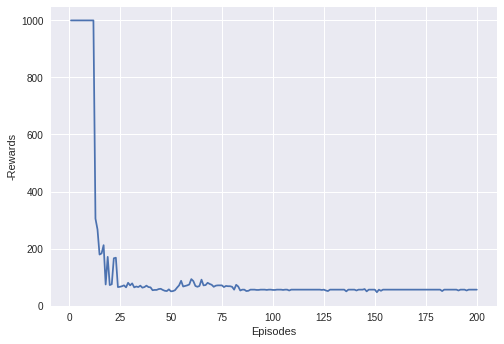

In [4]:
if __name__ == '__main__':
    MountainCarDemo(200) 